In [1]:
import copy
import os

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch
from tqdm.auto import tqdm
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import initialise, fill

In [2]:
n_ens = 1001

In [3]:
pd.options.display.max_columns = 50
df_configs = pd.read_csv('../data/fair2.1-parameters/calibrated_constrained_parameters_v1.3.1.csv', index_col=0)
valid_all = list(df_configs.index)[:n_ens]
df_configs

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,clim_F_4xCO2,cc_r0,cc_rU,cc_rT,cc_rA,ari_BC,ari_CH4,ari_N2O,ari_NH3,ari_NOx,ari_OC,ari_Sulfur,ari_VOC,ari_Equivalent effective stratospheric chlorine,aci_shape_so2,aci_shape_bc,aci_shape_oc,aci_beta,o3_CH4,o3_N2O,o3_Equivalent effective stratospheric chlorine,o3_CO,o3_VOC,o3_NOx,fscale_CH4,fscale_N2O,fscale_minorGHG,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_Contrails,fscale_CO2,cc_co2_concentration_1750,seed
394,5.196186,3.209179,26.504324,74.936014,1.045542,2.487784,1.063708,1.231824,1.274014,0.575318,5.446297,28.916092,0.007494,5.269876,-0.000766,0.021578,-4.524021e-06,-0.000066,-0.000201,-0.000119,-0.000711,-0.000894,-0.000012,-1.175845e-05,1.016966e-02,1.627794e+02,2.311596e-12,-0.636097,0.000207,0.001010,-0.000154,0.000100,0.000024,0.000537,0.973617,1.014046,1.031487,2.393013,1.537615,0.841857,0.866718,-0.023048,1.438652,2.110481,0.829897,276.973516,1512969
1850,2.288617,3.895453,21.631605,71.006254,1.114593,2.723680,0.810501,1.451213,0.383414,0.395347,6.573233,35.071581,0.002109,0.127773,0.004042,0.036803,-2.671106e-06,-0.000070,-0.000755,-0.000050,-0.004247,-0.002989,-0.000020,-1.466761e-05,2.293373e-07,1.001988e-06,5.100679e-07,-29629.248026,0.000301,0.000694,-0.000090,0.000098,-0.000055,0.001008,1.218315,1.023173,1.128139,2.067132,0.934253,1.099843,1.083101,-0.039804,1.827225,0.982702,0.905741,277.521081,2093913
1923,5.628552,3.201160,30.358740,69.274958,1.963336,3.091190,0.547595,1.226456,0.825602,0.307442,6.193044,35.845338,0.005620,0.053912,0.000521,0.010344,-3.605621e-06,-0.000072,-0.000040,-0.000105,-0.004093,-0.002707,-0.000022,-6.091752e-06,6.756019e-02,3.605812e-32,2.326726e-13,-0.238479,0.000190,0.001009,-0.000009,-0.000010,-0.000139,0.001231,1.032909,0.845890,0.905832,0.569276,1.006613,1.028865,1.200466,-0.029519,0.939350,-0.011421,0.879706,274.048094,2123040
2317,18.468801,3.163827,22.835474,121.188981,0.948618,4.202631,1.376017,1.239907,0.959614,0.644744,9.332195,32.566134,0.005682,3.811446,-0.000152,0.002476,-2.528352e-06,-0.000066,-0.000622,-0.000077,-0.002352,-0.003095,-0.000030,-1.438721e-05,6.807209e-02,6.275534e-42,7.727394e-01,-1.396332,0.000249,0.001339,-0.000112,0.000116,0.000043,0.000982,1.286672,1.037015,0.981106,0.726182,1.199499,0.952418,0.983109,-0.045739,0.075185,0.250826,1.091131,277.121190,2280246
2516,2.975201,5.319507,11.528340,105.104136,1.481714,1.045909,2.086986,1.826375,1.129155,0.512410,7.883999,35.843884,-0.001984,3.957324,0.002702,0.012479,-4.246126e-06,-0.000046,-0.000029,-0.000029,-0.007349,-0.000684,-0.000024,-5.339786e-06,6.791447e-03,1.646242e-05,4.559743e-11,-1.392941,0.000189,0.000984,-0.000135,0.000125,-0.000095,0.001599,0.886239,1.128136,0.828414,0.299357,0.889282,0.832298,1.123303,-0.052782,1.157428,0.924670,0.996611,279.909930,2359647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489640,4.221872,4.644720,37.805768,134.804349,1.471907,1.140970,0.727595,0.766440,0.924260,0.464464,7.016269,36.562135,-0.000058,2.375807,0.002957,0.021928,-1.171091e-06,-0.000070,-0.000972,-0.000088,-0.006967,-0.003678,-0.000014,-8.392443e-07,2.613794e-03,7.061138e-08,1.597420e-02,-2.183958,0.000293,0.001512,-0.000082,0.000006,-0.000107,0.003011,0.935437,0.878418,1.149302,0.815423,0.769640,1.195112,1.209793,-0.018162,0.836966,0.776115,0.937026,275.746463,595722123
1489982,2.702212,2.810514,6.023483,115.851261,1.235430,3.404036,1.113084,1.666329,0.700133,0.422100,6.714000,33.687355,0.004941,0.156718,0.001333,0.006681,-3.006400e-06,-0.000057,-0.000170,-0.000092,-0.002834,-0.001057,-0.000009,-4.446373e-06,6.595324e-03,3.375108e+02,5.192262e-12,-0.513438,0.000208,0.001872,-0.000053,0.000206,0.000267,0.000835,1.066506,0.87

In [4]:
df_configs.columns

Index(['clim_gamma', 'clim_c1', 'clim_c2', 'clim_c3', 'clim_kappa1',
       'clim_kappa2', 'clim_kappa3', 'clim_epsilon', 'clim_sigma_eta',
       'clim_sigma_xi', 'clim_F_4xCO2', 'cc_r0', 'cc_rU', 'cc_rT', 'cc_rA',
       'ari_BC', 'ari_CH4', 'ari_N2O', 'ari_NH3', 'ari_NOx', 'ari_OC',
       'ari_Sulfur', 'ari_VOC',
       'ari_Equivalent effective stratospheric chlorine', 'aci_shape_so2',
       'aci_shape_bc', 'aci_shape_oc', 'aci_beta', 'o3_CH4', 'o3_N2O',
       'o3_Equivalent effective stratospheric chlorine', 'o3_CO', 'o3_VOC',
       'o3_NOx', 'fscale_CH4', 'fscale_N2O', 'fscale_minorGHG',
       'fscale_Stratospheric water vapour', 'fscale_Land use',
       'fscale_Volcanic', 'fscale_solar_amplitude', 'fscale_solar_trend',
       'fscale_Light absorbing particles on snow and ice', 'fscale_Contrails',
       'fscale_CO2', 'cc_co2_concentration_1750', 'seed'],
      dtype='object')

In [5]:
df_solar = pd.read_csv(
    "../data/forcing/solar_erf_timebounds.csv", index_col="year"
)
df_volcanic = pd.read_csv(
    "../data/forcing/volcanic_sAOD_ERF_monthly_-950001-202212.csv"
)

In [6]:
volcanic_forcing = np.zeros(551)
for i, year in enumerate(np.arange(1750, 2024)):
    volcanic_forcing[i] = np.mean(
        df_volcanic.loc[
            ((year - 1) <= df_volcanic["year"]) & (df_volcanic["year"] < year)
        ].volcanic_ERF
    )
volcanic_forcing[273:283] = np.linspace(1, 0, 10) * volcanic_forcing[273]

In [7]:
solar_forcing=np.zeros(551)
solar_forcing_df = pd.read_csv('../data/forcing/solar_erf_timebounds.csv', index_col=0)
solar_forcing[:281] = solar_forcing_df['erf'].values[:281]
solar_forcing[271:281] = np.linspace(1, 0, 10) * solar_forcing[271:281]

In [8]:
trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

In [9]:
df_methane = pd.read_csv(
    "../data/fair2.1-parameters/CH4_lifetime.csv",
    index_col=0,
)

In [10]:
# scenarios:
# ssp119 and ssp534-over are copied from RCMIP, EXCEPT for
# - the correction to NOx emissions which are hand-edited to correct for the wrong units in RCMIP data 
#   (https://github.com/chrisroadmap/rcmip-nox-fix)
# - units of N2O and CO2 are converted to MtN2O and GtCO2 respectively
# COFFEE1.1 is taken from Camilla's extensions prepared for the PRIME analysis paper (Munday et al., in prep.)
# - NOx corrected. Had to estimate post-2015 land use component (not in scenario). Assumed constant.
# - aviation NOx, which is not included, is taken from SSP1-2.6.
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)
scenarios = ['ssp119', 'ssp534-over', 'COFFEE1.1 EN_NPi2020_400f_lowBECCS']
f.define_scenarios(scenarios)
species, properties = read_properties()
f.define_species(species, properties)
f.define_configs(list(valid_all))
f.allocate()

In [11]:
coffee = pd.read_csv('../data/emissions/COFFEE1.1___EN_NPi2020_400f_lowBECCS.csv', index_col=0)
ssp119 = pd.read_csv('../data/emissions/ssp119.csv', index_col=0)
ssp534 = pd.read_csv('../data/emissions/ssp534-over.csv', index_col=0)

In [12]:
# add in emissions
for specie in ssp119.index:
    f.emissions.loc[dict(scenario='ssp119', specie=specie)] = ssp119.loc[specie, :].interpolate().values[:-1][:, None]
for specie in ssp534.index:
    f.emissions.loc[dict(scenario='ssp534-over', specie=specie)] = ssp534.loc[specie, :].interpolate().values[:-1][:, None]
for specie in coffee.index:
    f.emissions.loc[dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', specie=specie)] = coffee.loc[specie, :].interpolate().values[:-1][:, None]

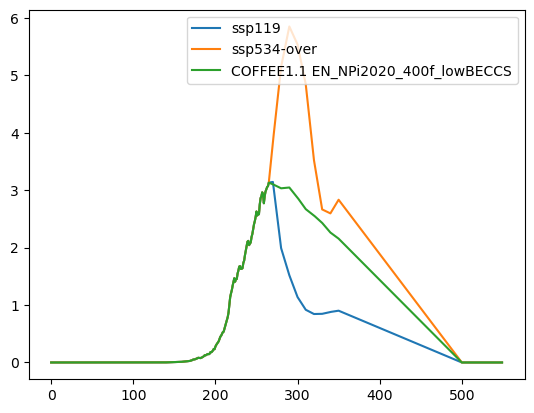

In [13]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='NOx aviation', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

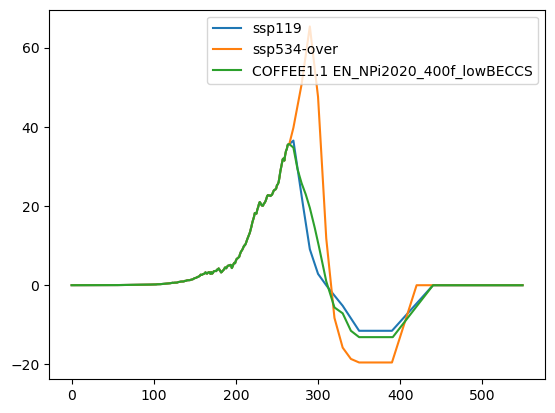

In [14]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='CO2 FFI', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

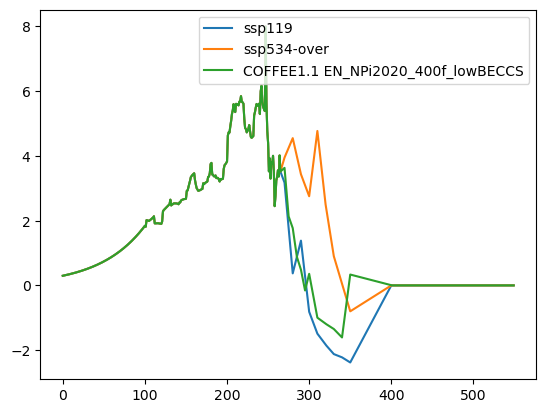

In [15]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='CO2 AFOLU', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

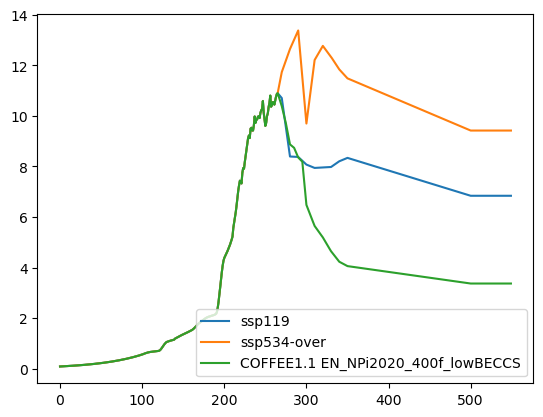

In [16]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='N2O', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

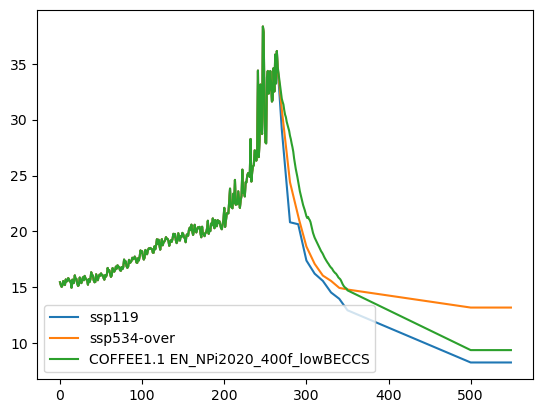

In [17]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='OC', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

In [18]:
# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs.loc[valid_all, "fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs.loc[valid_all, "fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs.loc[valid_all, "fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[valid_all, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all,"clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all,"clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs.loc[valid_all,"clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs.loc[valid_all,"clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs.loc[valid_all,"seed"])
fill(f.climate_configs["stochastic_run"], False)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs.loc[valid_all,"clim_F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs.loc[valid_all,"cc_r0"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_airborne"], df_configs.loc[valid_all,"cc_rA"].values.squeeze(), specie="CO2"
)
fill(f.species_configs["iirf_uptake"], df_configs.loc[valid_all,"cc_rU"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_temperature"],
    df_configs.loc[valid_all,"cc_rT"].values.squeeze(),
    specie="CO2",
)

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs.loc[valid_all,"aci_beta"].values.squeeze())
fill(
    f.species_configs["aci_shape"],
    df_configs.loc[valid_all,"aci_shape_so2"].values.squeeze(),
    specie="Sulfur",
)
fill(
    f.species_configs["aci_shape"], df_configs.loc[valid_all,"aci_shape_bc"].values.squeeze(), specie="BC"
)
fill(
    f.species_configs["aci_shape"], df_configs.loc[valid_all,"aci_shape_oc"].values.squeeze(), specie="OC"
)

# methane lifetime baseline and sensitivity
fill(
    f.species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f.species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f.species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs.loc[valid_all,f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Contrails",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs.loc[valid_all,f"fscale_{specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs.loc[valid_all,"fscale_minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs.loc[valid_all,f"o3_{specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs.loc[valid_all,"cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

f.run()

Running 3003 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

In [19]:
temp_norm_19952014 = np.ones(21)
temp_norm_19952014[0] = 0.5
temp_norm_19952014[-1] = 0.5

temp_norm_20032022 = np.ones(21)
temp_norm_20032022[0] = 0.5
temp_norm_20032022[-1] = 0.5

In [20]:
df_gmst = pd.read_csv('../data/constraints/IGCC_GMST_1850-2022.csv', index_col=0)

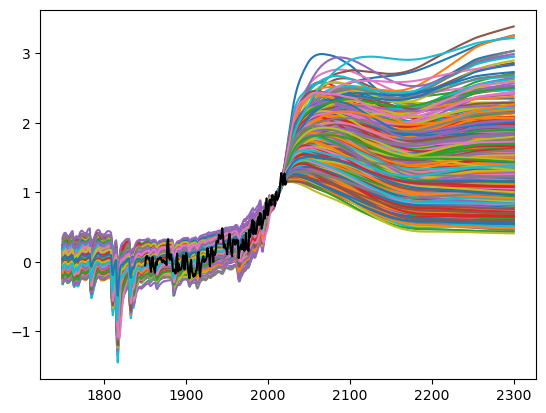

In [21]:
# ssp119
pl.plot(
    np.arange(1750, 2301),
    f.temperature[:, 0, :, 0].values - 
#    np.average(f.temperature[245:266, 0, :, 0].values, axis=0, weights=temp_norm_19952014) + 0.85
    np.average(f.temperature[253:274, 0, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')
#pl.xlim(1995, 2050)
#pl.ylim(0.5, 1.8)

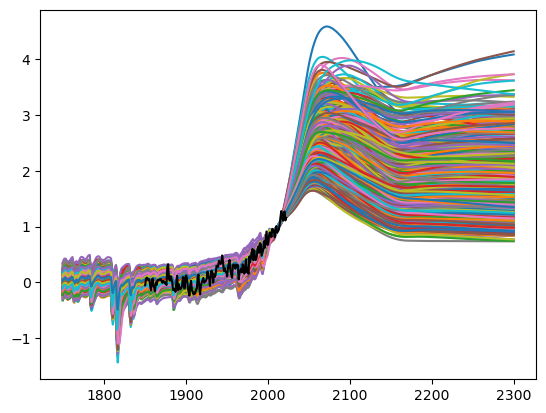

In [22]:
# ssp534
pl.plot(
    np.arange(1750, 2301),
    f.temperature[:, 1, :, 0].values - 
#    np.average(f.temperature[245:266, 0, :, 0].values, axis=0, weights=temp_norm_19952014) + 0.85
    np.average(f.temperature[253:274, 1, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

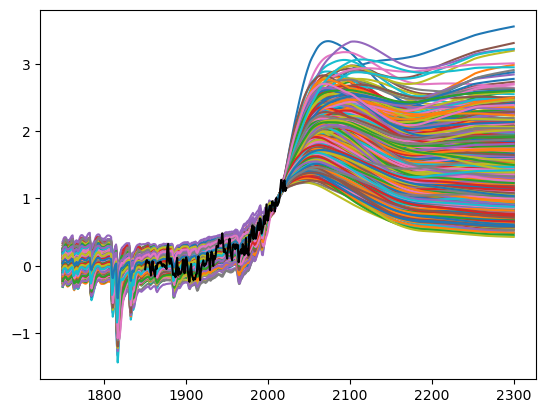

In [23]:
# coffee
pl.plot(
    np.arange(1750, 2301),
    f.temperature[:, 2, :, 0].values - 
#    np.average(f.temperature[245:266, 0, :, 0].values, axis=0, weights=temp_norm_19952014) + 0.85
    np.average(f.temperature[253:274, 2, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

In [24]:
# first index of 1.5C exceedence. If zero, run stays under 1.5C
exceeds_1p5_indices = np.argmax(
    f.temperature[:, :, :, 0].values - 
    np.average(f.temperature[253:274, 0, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03 > 1.5,
    axis=0
)
exceeds_1p5_indices

array([[301, 279,   0, ...,   0,   0, 293],
       [282, 277, 287, ..., 280, 281, 281],
       [289, 279,   0, ..., 286, 286, 287]])

In [25]:
# how many ensemble members exceed 1.5?
print(exceeds_1p5_indices[0, exceeds_1p5_indices[0, :]>0].shape)
print(exceeds_1p5_indices[1, exceeds_1p5_indices[1, :]>0].shape)
print(exceeds_1p5_indices[2, exceeds_1p5_indices[2, :]>0].shape)

(646,)
(1001,)
(877,)


In [26]:
# Check first year of exceeding 1.5C
print(np.min(exceeds_1p5_indices[0, exceeds_1p5_indices[0, :]>0]))
print(np.min(exceeds_1p5_indices[1, exceeds_1p5_indices[1, :]>0]))
print(np.min(exceeds_1p5_indices[2, exceeds_1p5_indices[2, :]>0]))

272
272
274


In [27]:
# does the config exceed 1.5C?
run_exceeds_1p5 = np.zeros_like(exceeds_1p5_indices, dtype=bool)
run_exceeds_1p5[exceeds_1p5_indices > 0] = True
run_exceeds_1p5

array([[ True,  True, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True]])

In [28]:
np.sum(run_exceeds_1p5)

2524

In [29]:
f_fut = {}

In [30]:
f_fut[2023] = FAIR(ch4_method="Thornhill2021")

In [31]:
f_fut[2023].define_time(1750, 2024, 1)

In [32]:
f_fut[2023].define_scenarios(scenarios)

In [33]:
species, properties = read_properties()

In [34]:
f_fut[2023].define_species(species, properties)

In [35]:
f_fut[2023].define_configs(valid_all)

In [36]:
f_fut[2023].configs

[394,
 1850,
 1923,
 2317,
 2516,
 4749,
 5862,
 6207,
 6837,
 6913,
 7127,
 10711,
 11410,
 12390,
 13787,
 15871,
 20289,
 20338,
 20526,
 21880,
 22812,
 25314,
 26292,
 27016,
 28108,
 30421,
 32781,
 38658,
 38942,
 43053,
 44501,
 47161,
 49942,
 56854,
 58045,
 60720,
 61215,
 64038,
 65691,
 66550,
 68400,
 68780,
 69857,
 71341,
 71522,
 73454,
 73844,
 74046,
 74219,
 74441,
 75970,
 79050,
 79690,
 80063,
 81918,
 82343,
 85911,
 92816,
 93397,
 94283,
 97893,
 98332,
 100273,
 103354,
 104698,
 105923,
 108916,
 110959,
 111341,
 111841,
 116975,
 117459,
 119586,
 121975,
 122359,
 124265,
 125143,
 126311,
 126748,
 128603,
 131918,
 134942,
 136135,
 138120,
 141593,
 141594,
 141797,
 142087,
 147716,
 152764,
 155460,
 155794,
 156235,
 157698,
 159310,
 160322,
 164612,
 165266,
 167003,
 168914,
 170240,
 170318,
 171308,
 172106,
 173682,
 175268,
 177962,
 178360,
 180890,
 180989,
 182276,
 184064,
 184499,
 185472,
 187192,
 187454,
 189535,
 190900,
 192189,
 19

In [37]:
f_fut[2023].allocate()

In [38]:
# add in emissions
for specie in ssp119.index:
    f_fut[2023].emissions.loc[dict(scenario='ssp119', specie=specie)] = ssp119.loc[specie, :].interpolate().values[:274][:, None]
for specie in ssp534.index:
    f_fut[2023].emissions.loc[dict(scenario='ssp534-over', specie=specie)] = ssp534.loc[specie, :].interpolate().values[:274][:, None]
for specie in coffee.index:
    f_fut[2023].emissions.loc[dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', specie=specie)] = coffee.loc[specie, :].interpolate().values[:274][:, None]

In [39]:
# solar and volcanic forcing
fill(
    f_fut[2023].forcing,
    volcanic_forcing[:275, None, None] * df_configs.loc[valid_all, "fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f_fut[2023].forcing,
    solar_forcing[:275, None, None] * df_configs.loc[valid_all, "fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:275, None, None] * df_configs.loc[valid_all, "fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(f_fut[2023].climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "clim_c1":"clim_c3"].values)
fill(
    f_fut[2023].climate_configs["ocean_heat_transfer"],
    df_configs.loc[valid_all, "clim_kappa1":"clim_kappa3"].values,
)
fill(f_fut[2023].climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all, "clim_epsilon"])
fill(f_fut[2023].climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all, "clim_gamma"])
fill(f_fut[2023].climate_configs["sigma_eta"], df_configs.loc[valid_all, "clim_sigma_eta"])
fill(f_fut[2023].climate_configs["sigma_xi"], df_configs.loc[valid_all, "clim_sigma_xi"])
fill(f_fut[2023].climate_configs["seed"], df_configs.loc[valid_all, "seed"])
fill(f_fut[2023].climate_configs["stochastic_run"], False)
fill(f_fut[2023].climate_configs["use_seed"], True)
fill(f_fut[2023].climate_configs["forcing_4co2"], df_configs.loc[valid_all, "clim_F_4xCO2"])

# species level
f_fut[2023].fill_species_configs()

# carbon cycle
fill(f_fut[2023].species_configs["iirf_0"], df_configs.loc[valid_all,"cc_r0"], specie="CO2")
fill(
    f_fut[2023].species_configs["iirf_airborne"], df_configs.loc[valid_all,"cc_rA"], specie="CO2"
)
fill(f_fut[2023].species_configs["iirf_uptake"], df_configs.loc[valid_all,"cc_rU"], specie="CO2")
fill(
    f_fut[2023].species_configs["iirf_temperature"],
    df_configs.loc[valid_all,"cc_rT"],
    specie="CO2",
)

# aerosol indirect
fill(f_fut[2023].species_configs["aci_scale"], df_configs.loc[valid_all,"aci_beta"])
fill(
    f_fut[2023].species_configs["aci_shape"],
    df_configs.loc[valid_all, "aci_shape_so2"],
    specie="Sulfur",
)
fill(
    f_fut[2023].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_bc"], specie="BC"
)
fill(
    f_fut[2023].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_oc"], specie="OC"
)

# methane lifetime baseline and sensitivity
fill(
    f_fut[2023].species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f_fut[2023].species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f_fut[2023].species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f_fut[2023].species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f_fut[2023].species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f_fut[2023].species_configs["erfari_radiative_efficiency"],
        df_configs.loc[valid_all, f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Contrails",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f_fut[2023].species_configs["forcing_scale"],
        df_configs.loc[valid_all, f"fscale_{specie}"],
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f_fut[2023].species_configs["forcing_scale"],
        df_configs.loc[valid_all,"fscale_minorGHG"],
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f_fut[2023].species_configs["ozone_radiative_efficiency"],
        df_configs.loc[valid_all, f"o3_{specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f_fut[2023].species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f_fut[2023].species_configs["baseline_concentration"],
    df_configs.loc[valid_all,"cc_co2_concentration_1750"],
    specie="CO2",
)

initialise(f_fut[2023].concentration, f_fut[2023].species_configs['baseline_concentration'])
initialise(f_fut[2023].forcing, 0)
initialise(f_fut[2023].temperature, 0)
initialise(f_fut[2023].airborne_emissions, 0)
initialise(f_fut[2023].cumulative_emissions, 0)

f_fut[2023].run()

Running 3003 projections in parallel:   0%|          | 0/274 [00:00<?, ?timesteps/s]

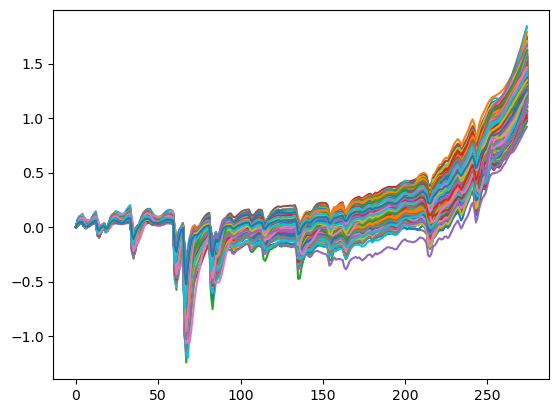

In [40]:
pl.plot(f_fut[2023].temperature[:,0,:,0]);

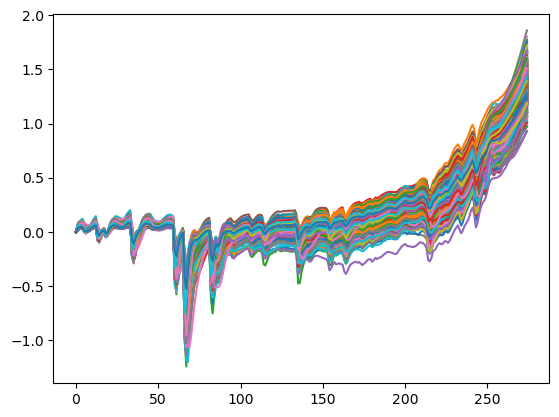

In [41]:
pl.plot(f_fut[2023].temperature[:,1,:,0]);

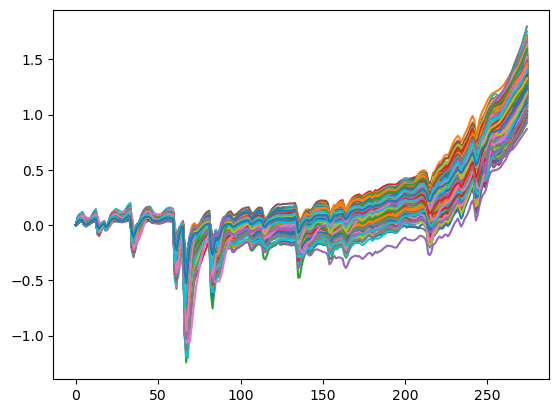

In [42]:
pl.plot(f_fut[2023].temperature[:,2,:,0]);

In [43]:
for year in tqdm(range(2024, 2300)):
    run = 0
    f_fut[year] = FAIR(ch4_method="Thornhill2021")
    f_fut[year].define_time(year, year+1, 1)
    f_fut[year].define_scenarios(scenarios)
    f_fut[year].define_species(species, properties)
    f_fut[year].define_configs(valid_all)
    f_fut[year].allocate()
    
    # emissions in
    for specie in ssp119.index:
        f_fut[year].emissions.loc[dict(scenario='ssp119', specie=specie)] = ssp119.loc[specie, :].interpolate().values[year-1750]
    for specie in ssp534.index:
        f_fut[year].emissions.loc[dict(scenario='ssp534-over', specie=specie)] = ssp534.loc[specie, :].interpolate().values[year-1750]
    for specie in coffee.index:
        f_fut[year].emissions.loc[dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', specie=specie)] = coffee.loc[specie, :].interpolate().values[year-1750]
    
    # climate response
    fill(f_fut[year].climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "clim_c1":"clim_c3"].values)
    fill(
        f_fut[year].climate_configs["ocean_heat_transfer"],
        df_configs.loc[valid_all, "clim_kappa1":"clim_kappa3"].values,
    )
    fill(f_fut[year].climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all, "clim_epsilon"])
    fill(f_fut[year].climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all, "clim_gamma"])
    fill(f_fut[year].climate_configs["sigma_eta"], df_configs.loc[valid_all, "clim_sigma_eta"])
    fill(f_fut[year].climate_configs["sigma_xi"], df_configs.loc[valid_all, "clim_sigma_xi"])
    fill(f_fut[year].climate_configs["seed"], df_configs.loc[valid_all, "seed"])
    fill(f_fut[year].climate_configs["stochastic_run"], False)
    fill(f_fut[year].climate_configs["use_seed"], True)
    fill(f_fut[year].climate_configs["forcing_4co2"], df_configs.loc[valid_all, "clim_F_4xCO2"])

    # species level
    f_fut[year].fill_species_configs()

    # carbon cycle
    fill(f_fut[year].species_configs["iirf_0"], df_configs.loc[valid_all,"cc_r0"], specie="CO2")
    fill(
        f_fut[year].species_configs["iirf_airborne"], df_configs.loc[valid_all,"cc_rA"], specie="CO2"
    )
    fill(f_fut[year].species_configs["iirf_uptake"], df_configs.loc[valid_all,"cc_rU"], specie="CO2")
    fill(
        f_fut[year].species_configs["iirf_temperature"],
        df_configs.loc[valid_all,"cc_rT"],
        specie="CO2",
    )

    # aerosol indirect
    fill(f_fut[year].species_configs["aci_scale"], df_configs.loc[valid_all,"aci_beta"])
    fill(
        f_fut[year].species_configs["aci_shape"],
        df_configs.loc[valid_all, "aci_shape_so2"],
        specie="Sulfur",
    )
    fill(
        f_fut[year].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_bc"], specie="BC"
    )
    fill(
        f_fut[year].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_oc"], specie="OC"
    )

    # methane lifetime baseline and sensitivity
    fill(
        f_fut[year].species_configs["unperturbed_lifetime"],
        df_methane.loc["historical_best", "base"],
        specie="CH4",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "CH4"],
        specie="CH4",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "N2O"],
        specie="N2O",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "VOC"],
        specie="VOC",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "NOx"],
        specie="NOx",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "HC"],
        specie="Equivalent effective stratospheric chlorine",
    )
    fill(
        f_fut[year].species_configs["lifetime_temperature_sensitivity"],
        df_methane.loc["historical_best", "temp"],
    )

    # emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
    # might wanna run pulse expts with these gases)
    fill(f_fut[year].species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
    fill(f_fut[year].species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
    fill(f_fut[year].species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

    # aerosol direct
    for specie in [
        "BC",
        "CH4",
        "N2O",
        "NH3",
        "NOx",
        "OC",
        "Sulfur",
        "VOC",
        "Equivalent effective stratospheric chlorine",
    ]:
        fill(
            f_fut[year].species_configs["erfari_radiative_efficiency"],
            df_configs.loc[valid_all, f"ari_{specie}"],
            specie=specie,
        )

    # forcing scaling
    for specie in [
        "CO2",
        "CH4",
        "N2O",
        "Stratospheric water vapour",
        "Contrails",
        "Light absorbing particles on snow and ice",
        "Land use",
    ]:
        fill(
            f_fut[year].species_configs["forcing_scale"],
            df_configs.loc[valid_all, f"fscale_{specie}"],
            specie=specie,
        )

    for specie in [
        "CFC-11",
        "CFC-12",
        "CFC-113",
        "CFC-114",
        "CFC-115",
        "HCFC-22",
        "HCFC-141b",
        "HCFC-142b",
        "CCl4",
        "CHCl3",
        "CH2Cl2",
        "CH3Cl",
        "CH3CCl3",
        "CH3Br",
        "Halon-1211",
        "Halon-1301",
        "Halon-2402",
        "CF4",
        "C2F6",
        "C3F8",
        "c-C4F8",
        "C4F10",
        "C5F12",
        "C6F14",
        "C7F16",
        "C8F18",
        "NF3",
        "SF6",
        "SO2F2",
        "HFC-125",
        "HFC-134a",
        "HFC-143a",
        "HFC-152a",
        "HFC-227ea",
        "HFC-23",
        "HFC-236fa",
        "HFC-245fa",
        "HFC-32",
        "HFC-365mfc",
        "HFC-4310mee",
    ]:
        fill(
            f_fut[year].species_configs["forcing_scale"],
            df_configs.loc[valid_all,"fscale_minorGHG"],
            specie=specie,
        )

    # ozone
    for specie in [
        "CH4",
        "N2O",
        "Equivalent effective stratospheric chlorine",
        "CO",
        "VOC",
        "NOx",
    ]:
        fill(
            f_fut[year].species_configs["ozone_radiative_efficiency"],
            df_configs.loc[valid_all, f"o3_{specie}"],
            specie=specie,
        )

    # tune down volcanic efficacy
    fill(f_fut[year].species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


    # initial condition of CO2 concentration (but not baseline for forcing calculations)
    fill(
        f_fut[year].species_configs["baseline_concentration"],
        df_configs.loc[valid_all,"cc_co2_concentration_1750"],
        specie="CO2",
    )
    
    while True:
        run = run+1
        initialise(f_fut[year].concentration, f_fut[year-1].concentration[-1, ...])
        initialise(f_fut[year].forcing, f_fut[year-1].forcing[-1, ...])
        initialise(f_fut[year].temperature, f_fut[year-1].temperature[-1, ...])
        initialise(f_fut[year].airborne_emissions, f_fut[year-1].airborne_emissions[-1, ...])
        initialise(f_fut[year].cumulative_emissions, f_fut[year-1].cumulative_emissions[-1, ...])
        initialise(f_fut[year].alpha_lifetime, f_fut[year-1].alpha_lifetime[-1, ...])
        f_fut[year].gas_partitions=copy.deepcopy(f_fut[year-1].gas_partitions)
        
        # Volcanic forcing
        fill(
            f_fut[year].forcing, 
            volcanic_forcing[year-1750:year-1749, None, None] * 
            df_configs.loc[valid_all, 'fscale_Volcanic'].values.squeeze(), 
            specie='Volcanic'
        )

        # Solar forcing
        fill(f_fut[year].forcing, 
             solar_forcing[year-1750:year-1749, None, None] * 
             df_configs.loc[valid_all, 'fscale_solar_amplitude'].values.squeeze() + 
             trend_shape[year-1750:year-1749, None, None] * df_configs.loc[valid_all, 'fscale_solar_trend'].values.squeeze(),
             specie='Solar'
        )

        # do the run
        f_fut[year].run(progress=False)
        
        # naive optimizer!
        t_anom = (f_fut[year].temperature[-1, :, :, 0] - np.average(f_fut[2023].temperature[253:274, :, :, 0], weights=temp_norm_20032022, axis=0)) + 1.03
        c_ch4 = f_fut[year].concentration[-1, :, :, 3]
        
        #print(f"temperature in {year} is {t_anom.values}")
        overshoot_configs = np.logical_and(t_anom>1.5, c_ch4>50)
        print(np.sum(overshoot_configs).values)
        
        # all below 1.5C? great; move on to next year, else continue
        if np.sum(overshoot_configs).values==0:# or run>=100:
            break
        
        shave = np.zeros_like(t_anom)
        #shave[overshoot_configs] = np.maximum(10, (t_anom.values[overshoot_configs]-1.5)*10000)
        shave[overshoot_configs] = 20
        f_fut[year].emissions[0, :, :, 3] = f_fut[year].emissions[0, :, :, 3] - shave

  0%|          | 0/276 [00:00<?, ?it/s]

197
190
186
184
183
182
180
177
175
174
171
169
169
167
164
162
159
158
156
154
153
152
152
150
148
146
143
142
139
139
138
138
133
131
130
127
125
121
121
120
116
116
116
115
114
114
112
111
111
111
111
110
107
106
104
103
101
101
98
94
94
94
94
93
93
93
91
89
88
84
83
83
81
79
79
77
77
76
75
73
73
71
71
70
70
70
70
70
69
69
69
69
68
66
66
66
64
63
62
61
61
60
58
57
56
56
56
56
55
55
55
53
51
50
47
47
47
46
46
45
45
45
44
44
44
40
40
40
40
40
40
40
40
39
38
38
37
35
34
34
33
33
32
32
32
31
31
31
30
29
28
28
28
28
28
28
28
27
26
25
25
25
24
24
23
23
23
22
21
21
21
21
21
20
19
19
19
18
17
17
17
17
17
17
17
17
16
16
16
16
16
16
16
16
16
16
15
15
14
14
14
13
13
13
13
13
13
12
12
12
12
12
12
12
12
12
11
11
11
11
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
8
7
7
6
6
6
6
6
6
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
345
332
327
324
320
317
309
301
298
295
288
284
281
277
272
267
264
257
256
252
248
246
240
235
234
231
226
222
214

In [44]:
concentration_opt = np.zeros((551, n_ens))
concentration_opt[:275] = f_fut[2023].concentration[:, 0, :, 3]
for year in range(2024, 2300):
    concentration_opt[year-1749] = f_fut[year].concentration[1, 0, :, 3]

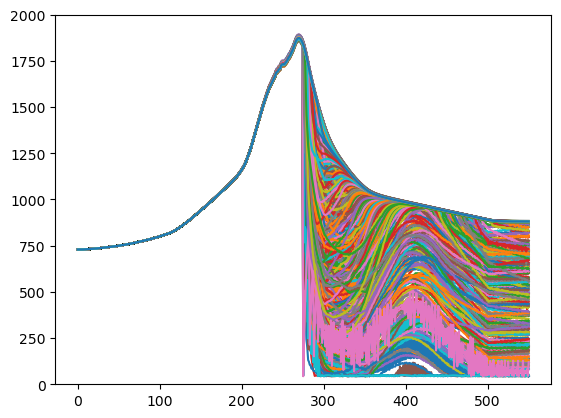

In [45]:
pl.plot(concentration_opt);
pl.ylim(0,2000);

In [46]:
# for year in range(2015, 2300):
#     pl.plot(f_fut[year].timebounds, f_fut[year].temperature[:, 0, :, 0] - np.average(f_fut[2015].temperature[245:266, 0, :, 0], axis=0, weights=temp_norm_19952014) + 0.85, color='k')
# pl.plot(f.timebounds[250:], f.temperature[250:,0,:,0] - np.average(f.temperature[245:266, 0, :, 0], axis=0, weights=temp_norm_19952014) + 0.85, color='r')

In [47]:
species[58]

'Ozone'

In [48]:
emissions_opt = np.zeros((550, 3, n_ens))
emissions_opt[:274] = f_fut[2023].emissions[:, :, :, 3]
for year in range(2024, 2300):
    emissions_opt[year-1750] = f_fut[year].emissions[:, :, :, 3]
    
concentration_opt = np.zeros((551, 3, n_ens))
concentration_opt[:275] = f_fut[2023].concentration[:, :, :, 3]
for year in range(2024, 2300):
    concentration_opt[year-1749] = f_fut[year].concentration[1, :, :, 3]

forcing_ch4_opt = np.zeros((551, 3, n_ens))
forcing_ch4_opt[:275] = f_fut[2023].forcing[:, :, :, 3]
for year in range(2024, 2300):
    forcing_ch4_opt[year-1749] = f_fut[year].forcing[1, :, :, 3]

forcing_o3_opt = np.zeros((551, 3, n_ens))
forcing_o3_opt[:275] = f_fut[2023].forcing[:, :, :, 58]
for year in range(2024, 2300):
    forcing_o3_opt[year-1749] = f_fut[year].forcing[1, :, :, 58]    
    
forcing_sum_opt = np.zeros((551, 3, n_ens))
forcing_sum_opt[:275] = f_fut[2023].forcing_sum
for year in range(2024, 2300):
    forcing_sum_opt[year-1749] = f_fut[year].forcing_sum[1, :, :]
    
temperature_opt = np.zeros((551, 3, n_ens))
temperature_opt[:275] = f_fut[2023].temperature[:, :, :, 0]
for year in range(2024, 2300):
    temperature_opt[year-1749] = f_fut[year].temperature[1, :, :, 0]
    
lifetime_opt = np.zeros((551, 3, n_ens))
lifetime_opt[:275] = f_fut[2023].alpha_lifetime[:, :, :, 3] * df_methane.loc["historical_best", "base"]
for year in range(2024, 2300):
    lifetime_opt[year-1749] = f_fut[year].alpha_lifetime[0, :, :, 3] * df_methane.loc["historical_best", "base"]

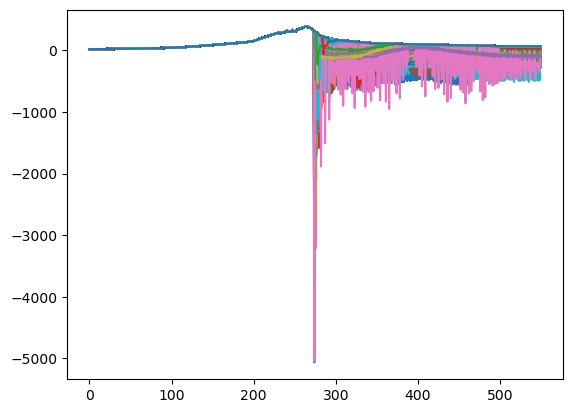

In [49]:
pl.plot(emissions_opt[:, 0, :]);

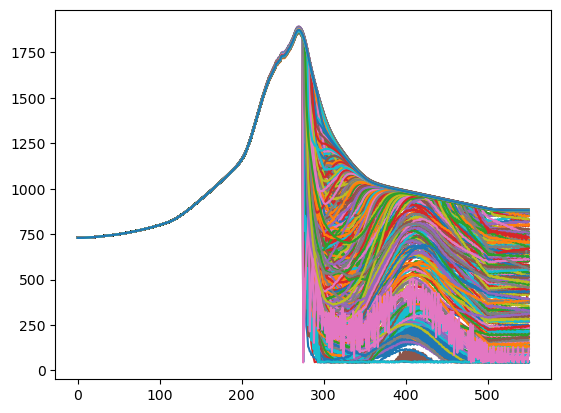

In [50]:
pl.plot(concentration_opt[:, 0, :]);

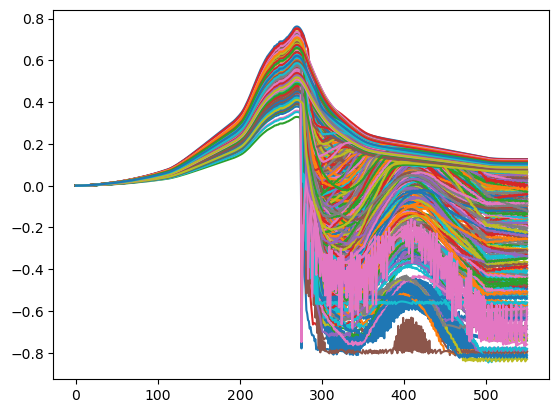

In [51]:
pl.plot(forcing_ch4_opt[:, 0, :]);

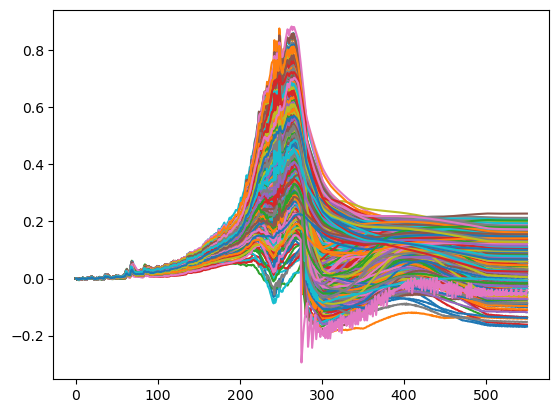

In [52]:
pl.plot(forcing_o3_opt[:, 0, :]);

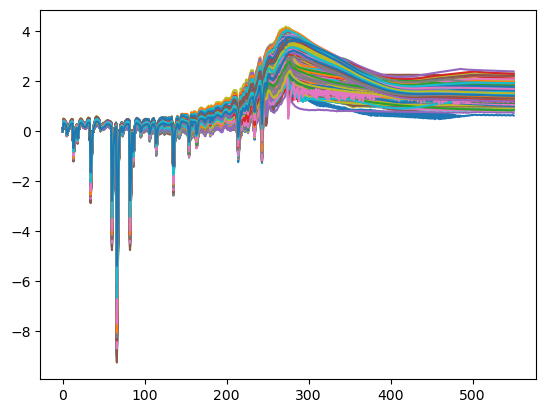

In [53]:
pl.plot(forcing_sum_opt[:, 0, :]);

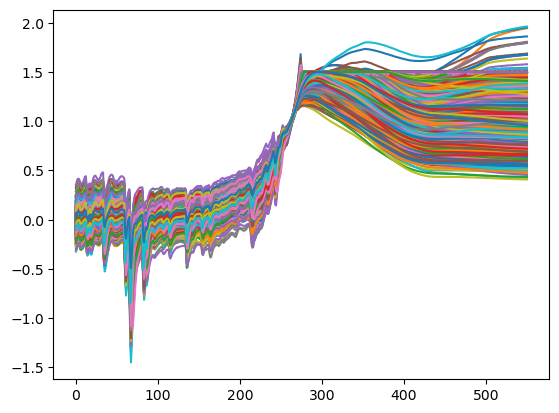

In [54]:
pl.plot(1.03 + temperature_opt[:, 0, :] - np.average(temperature_opt[253:274, 0, :], weights=temp_norm_20032022, axis=0));

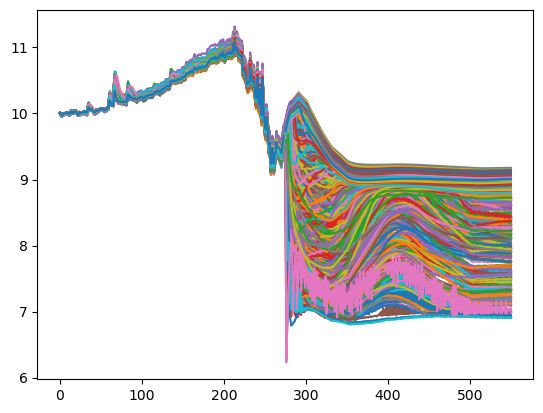

In [55]:
pl.plot(lifetime_opt[:, 0, :]);

In [56]:
ds_opt = xr.Dataset(
    data_vars = dict(
        emissions = (["timepoint", "scenario", "config"], emissions_opt),
        concentration = (["timebound", "scenario", "config"], concentration_opt),
        forcing_ch4 = (["timebound", "scenario", "config"], forcing_ch4_opt),
        forcing_o3 = (["timebound", "scenario", "config"], forcing_o3_opt),
        forcing_sum = (["timebound", "scenario", "config"], forcing_sum_opt),
        temperature = (["timebound", "scenario", "config"], temperature_opt),
        lifetime = (["timebound", "scenario", "config"], lifetime_opt),
    ),
    coords = dict(
        timepoint=np.arange(1750.5, 2300),
        timebound=np.arange(1750, 2301),
        scenario=scenarios,
        config=valid_all
    )
)

In [57]:
ds_opt

<xarray.Dataset>
Dimensions:        (timepoint: 550, scenario: 3, config: 1001, timebound: 551)
Coordinates:
  * timepoint      (timepoint) float64 1.75e+03 1.752e+03 ... 2.298e+03 2.3e+03
  * timebound      (timebound) int64 1750 1751 1752 1753 ... 2297 2298 2299 2300
  * scenario       (scenario) <U34 'ssp119' ... 'COFFEE1.1 EN_NPi2020_400f_lo...
  * config         (config) int64 394 1850 1923 2317 ... 1493662 1495531 1495865
Data variables:
    emissions      (timepoint, scenario, config) float64 19.02 19.02 ... 119.7
    concentration  (timebound, scenario, config) float64 729.2 ... 1.078e+03
    forcing_ch4    (timebound, scenario, config) float64 0.0 0.0 ... 0.2283
    forcing_o3     (timebound, scenario, config) float64 0.0 0.0 ... 0.09017
    forcing_sum    (timebound, scenario, config) float64 0.0 0.0 ... 1.458 1.497
    temperature    (timebound, scenario, config) float64 0.0 0.0 ... 0.9865
    lifetime       (timebound, scenario, config) float64 10.01 10.01 ... 9.854

In [58]:
os.makedirs('../results', exist_ok=True)

In [59]:
f.to_netcdf('../results/noCH4R.nc')

In [60]:
ds_opt.to_netcdf('../results/CH4R.nc')

In [61]:
(f.alpha_lifetime[:, :, :, 3] * df_methane.loc["historical_best", "base"])

<xarray.DataArray (timebounds: 551, scenario: 3, config: 1001)>
array([[[10.0069821 , 10.0069821 , 10.0069821 , ..., 10.0069821 ,
         10.0069821 , 10.0069821 ],
        [10.0069821 , 10.0069821 , 10.0069821 , ..., 10.0069821 ,
         10.0069821 , 10.0069821 ],
        [10.0069821 , 10.0069821 , 10.0069821 , ..., 10.0069821 ,
         10.0069821 , 10.0069821 ]],

       [[ 9.98323453,  9.98523488,  9.98162352, ...,  9.98567555,
          9.9746895 ,  9.9852187 ],
        [ 9.98323453,  9.98523488,  9.98162352, ...,  9.98567555,
          9.9746895 ,  9.9852187 ],
        [ 9.98323453,  9.98523488,  9.98162352, ...,  9.98567555,
          9.9746895 ,  9.9852187 ]],

       [[ 9.96902189,  9.96798549,  9.9696848 , ...,  9.97268689,
          9.96500615,  9.97191162],
        [ 9.96902189,  9.96798549,  9.9696848 , ...,  9.97268689,
          9.96500615,  9.97191162],
        [ 9.96902189,  9.96798549,  9.9696848 , ...,  9.97268689,
          9.96500615,  9.97191162]],
...
       [[ 8.85733087,  8.92143022,  9.13181574, ...,  8.95968309,
          9.0039041 ,  9.00984444],
        [ 8.68172148,  8.75319201,  9.02583202, ...,  8.75848713,
          8.86364873,  8.87782166],
        [ 9.6551084 ,  9.73581027, 10.00539495, ...,  9.80768659,
          9.85889158,  9.84959941]],

       [[ 8.8575295 ,  8.92173859,  9.1321762 , ...,  8.96018692,
          9.00421851,  9.01034917],
        [ 8.68200807,  8.75368705,  9.02632897, ...,  8.75909465,
          8.86414553,  8.87855798],
        [ 9.6555083 ,  9.73634456, 10.00592335, ...,  9.80847191,
          9.859399  ,  9.85036543]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.751e+03 ... 2.299e+03 2.3e+03
  * scenario    (scenario) <U34 'ssp119' ... 'COFFEE1.1 EN_NPi2020_400f_lowBE...
  * config      (config) int64 394 1850 1923 2317 ... 1493662 1495531 1495865
    specie      <U43 'CH4'

In [62]:
# Save lifetime
(f.alpha_lifetime[:, :, :, 3] * df_methane.loc["historical_best", "base"]).to_netcdf('../results/noCH4R_lifetime.nc')

In [63]:
# NEED TO GATHER INTO A DATASET

# pd.DataFrame(concentration_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_concentrations.csv')
# pd.DataFrame(emissions_opt, index=f.timepoints, columns=valid_all).to_csv('../results/ssp119_CH4R_emissions.csv')
# pd.DataFrame(forcing_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_forcing.csv')
# pd.DataFrame(temperature_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_temperature.csv')
# pd.DataFrame(forcing_sum_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_forcing_sum.csv')
# pd.DataFrame(lifetime_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_lifetime.csv')
pd.DataFrame(np.array([f.ebms.ecs, f.ebms.tcr]).T, index=valid_all, columns=['ECS', 'TCR']).to_csv('../results/ecs_tcr.csv')